# Spatial analysis

## Table of contents

### [1. Libraries and Data importations](#1)
### [2. Map visualizations](#2)

-[ Subset & wrangle dataframes](#2.1)

-[ Geojson import](#2.2)

-[ Map of causes of deaths and health providers' expenditures (FOLIUM)](#2.3)

-[ Map of the evolution of health providers' expenditures (PLOTLY)](#2.4) - deleted to make the file lighter

## 1. Libraries and Data importations
<div id='1'></div>

In [4]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import os
import matplotlib
import seaborn as sns
import folium
import json
import plotly.express as px

 

##to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Creating paths to the data folder of the project and to the folder for saving the charts
path_data = r'C:\Users\dacol\Documents\Data Project - careerfoundry\Europe health-deaths analysis\02 Data'
path_viz = r'C:\Users\dacol\Documents\Data Project - careerfoundry\Europe health-deaths analysis\04 Analysis\Visualizations'

# Importing the latest merged dataframe
df = pd.read_pickle(os.path.join(path_data,'Prepared Data','cod_merged_full.pkl'))


## 2. Map visualizations
<div id='2'></div>

### Subset & wrangle dataframes
<div id='2.1'></div>

In [7]:
sub_country = df[df['geo_code'].str.len() == 2]
df_country = sub_country[['geo_code', 'A-R_V-Y: All causes of death (A00-Y89) excluding S00-T98']]
df_country.head()

geo_code  A-R_V-Y: All causes of death (A00-Y89) excluding S00-T98
0       AT                                             920.47       
1       AT                                            4051.37       
2       AT                                             131.62       
3       AT                                             880.37       
4       AT                                            4402.11

In [8]:
df_country.isnull().sum() # One null value to drop

geo_code                                                    0
A-R_V-Y: All causes of death (A00-Y89) excluding S00-T98    1
dtype: int64

In [9]:
#Droping the null value
df_country.dropna()

geo_code  A-R_V-Y: All causes of death (A00-Y89) excluding S00-T98
0           AT                                             920.47       
1           AT                                            4051.37       
2           AT                                             131.62       
3           AT                                             880.37       
4           AT                                            4402.11       
...        ...                                                ...       
43330       UK                                            4397.99       
43331       UK                                             211.58       
43332       UK                                             919.13       
43333       UK                                            4229.64       
43334       UK                                             176.11       

[3339 rows x 2 columns]

<Axes: xlabel='A-R_V-Y: All causes of death (A00-Y89) excluding S00-T98', ylabel='Count'>

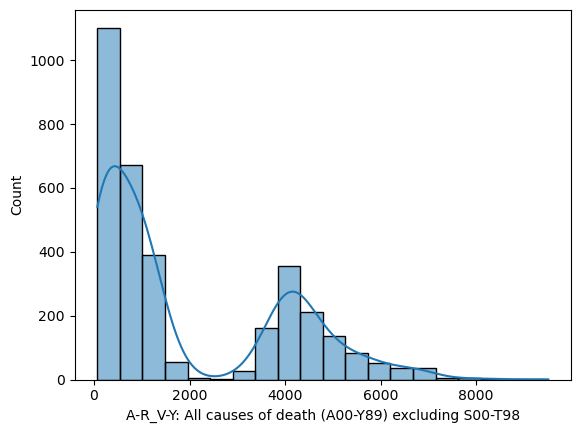

In [10]:
#ploting a histogram to check the distribution (looking for outliers)
sns.histplot(df_country['A-R_V-Y: All causes of death (A00-Y89) excluding S00-T98'], bins=20, kde = True) # shows extreme values for teh causes of deaths
                                                                                                            # no outlier found

In [11]:
# creating a subset of all expenditures (since values are only available for countries and no regions, many null values are expected and delt with directly)
sub = df[["geo_code","euros_per_inhabitant"]].dropna().groupby(by='geo_code').mean().reset_index() # means in order to account for all years
sub.head()

geo_code  euros_per_inhabitant
0       AT           4344.651818
1       BE           4111.598182
2       BG            554.770909
3       CH           7981.918182
4       CY           1698.708182

<Axes: xlabel='euros_per_inhabitant', ylabel='Count'>

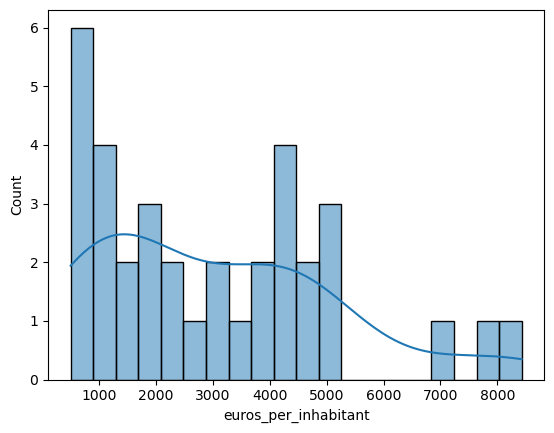

In [12]:
#ploting a histogram to check the distribution (looking for outliers)
sns.histplot(sub['euros_per_inhabitant'], bins=20, kde = True) # shows extreme values for the mean expenditures - no outlier found

### Geojson import
<div id='2.2'></div>

In [14]:
#Importing a local Geojson dowloaded from Eurostat Gisco oficial site
nut2_geo = json.load(open(r"C:\Users\dacol\Documents\Data Project - careerfoundry\Europe health-deaths analysis\02 Data\Original Data\Code lists\NUTS_RG_20M_2021_4326.geojson",'rb'))

In [15]:
#Exploring the geojson file to find the keys
nut2_geo['features'][0]['properties'].keys() #'NUTS_ID' and 'CNTR_CODE' can be used as keys

dict_keys(['NUTS_ID', 'LEVL_CODE', 'CNTR_CODE', 'NAME_LATN', 'NUTS_NAME', 'MOUNT_TYPE', 'URBN_TYPE', 'COAST_TYPE'])

### Map of causes of deaths and health providers' expenditures (FOLIUM)
<div id='2.3'></div>

In [17]:
#Final map definition
whole_map = folium.Map(location=(57.5468738, 9.8711543), zoom_start = 3.6, tiles='CartoDB.VoyagerNoLabels', overlay=True)

#Defining each layer
fig1 = folium.FeatureGroup(name='All causes of deaths rates (per 100k inhabitants)',overlay=True).add_to(whole_map)
fig2 = folium.FeatureGroup(name='Euros spent by healthcare providers per inhabitant',overlay=True).add_to(whole_map)

#First choropleth map accounting all deaths rates per 100K inhabitants
Deaths = folium.Choropleth(
    geo_data=nut2_geo,
    key_on='feature.properties.CNTR_CODE',
    data=df_country,
    columns=['geo_code','A-R_V-Y: All causes of death (A00-Y89) excluding S00-T98'],
    fill_color="YlGnBu",
    fill_opacity=1,
    line_opacity=0.3,
    highlight=True,
    nan_fill_color= "none",
    legend_name="All causes of deaths (per 100k inhabitants)",
    overlay=False).geojson.add_to(fig1)

#Second choropleth map showing the expenditure of healtcare providers
Euros = folium.Choropleth(
    geo_data=nut2_geo,
    key_on='feature.properties.NUTS_ID',
    data=sub,
    columns=['geo_code','euros_per_inhabitant'],
    fill_color="YlGnBu",
    fill_opacity=1,
    line_opacity=0.3,
    highlight=True,
    nan_fill_color= "none",
    legend_name="Euros per inhabitant",
    overlay=False,).geojson.add_to(fig2)

#adding a title to the map
map_title = "Deaths rates vs euros spent by healthcare providers"
title_html = f'<h1 style="position:absolute;z-index:100000;right:80vw" >{map_title}</h1>'
whole_map.get_root().html.add_child(folium.Element(title_html))

#adding a layer control
folium.LayerControl(collapsed=False).add_to(whole_map)

#saving the map to html
whole_map.save(os.path.join(path_viz,'Double_choropleth_deaths_euros.html'))

whole_map

**Deaths rates and healthcare expenditures**
- Countries with very low healtcare providers expenditures are the one with the most deaths (all causes) per 100K inhabitants
- There is a clear seperation form west and north to east, with more spending and less dying population on the west and north
- The relation from the latest study is well illustrated in this map